<h1 align="center"> Theft Detection Using Smart Meter Analysis </h1>
    
This notebook contains analysis of data and **our approach** for theft detection


**Table of Contents**

- [Data Description and Loading](#1.-Data-Description-and-Loading)
- [Data Analysis and Preprocessing](#2.-Data-Analysis-and-Preprocessing)
- [Clustering](#3.-Clustering)
- [Data Manipulation](#4.-Data-Manipulation)
- [Model Building with Hyperparameter Tuning](#5.-Model-Building)

In [1]:
## importing libraries
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import optuna
from tqdm.notebook import tqdm as tn
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score, auc, roc_curve

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

%matplotlib inline

## 1. Data Description and Loading

Given data is a refactored version of original smart meter data where the aggregations is performed on the half_hourly dataset to convert it to dataset

We will use daily basis data for smart meter analysis as a representative averge of overall day

**For more information about data, Read this [Article](https://medium.com/@boitemailjeanmid/smart-meters-in-london-part1-description-and-first-insights-jean-michel-d-db97af2de71b)**

In [2]:
#loading data
daily = pd.read_csv("../input/smart-meter-daily/daily_dataset.csv")
weather = pd.read_csv("../input/smart-meters-in-london/weather_daily_darksky.csv")
daily

,LCLid,day,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min
0,MAC000131,2011-12-15,0.4850,0.432045,0.868,22,0.239146,9.505,0.072
1,MAC000131,2011-12-16,0.1415,0.296167,1.116,48,0.281471,14.216,0.031
2,MAC000131,2011-12-17,0.1015,0.189812,0.685,48,0.188405,9.111,0.064
3,MAC000131,2011-12-18,0.1140,0.218979,0.676,48,0.202919,10.511,0.065
4,MAC000131,2011-12-19,0.1910,0.325979,0.788,48,0.259205,15.647,0.066
...,...,...,...,...,...,...,...,...,...
3510428,MAC004977,2014-02-24,0.0950,0.118458,0.580,48,0.093814,5.686,0.052
3510429,MAC004977,2014-02-25,0.0675,0.084208,0.176,48,0.037107,4.042,0.046
3510430,MAC004977,2014-02-26,0.1080,0.120500,0.282,48,0.069332,5.784,0.046
3510431,MAC004977,2014-02-27,0.0720,0.114062,0.431,48,0.094482,5.475,0.047


In [3]:
weather.head()

,temperatureMax,temperatureMaxTime,windBearing,icon,dewPoint,temperatureMinTime,cloudCover,windSpeed,pressure,apparentTemperatureMinTime,...,temperatureHigh,sunriseTime,temperatureHighTime,uvIndexTime,summary,temperatureLowTime,apparentTemperatureMin,apparentTemperatureMaxTime,apparentTemperatureLowTime,moonPhase
0,11.96,2011-11-11 23:00:00,123,fog,9.40,2011-11-11 07:00:00,0.79,3.88,1016.08,2011-11-11 07:00:00,...,10.87,2011-11-11 07:12:14,2011-11-11 19:00:00,2011-11-11 11:00:00,Foggy until afternoon.,2011-11-11 19:00:00,6.48,2011-11-11 23:00:00,2011-11-11 19:00:00,0.52
1,8.59,2011-12-11 14:00:00,198,partly-cloudy-day,4.49,2011-12-11 01:00:00,0.56,3.94,1007.71,2011-12-11 02:00:00,...,8.59,2011-12-11 07:57:02,2011-12-11 14:00:00,2011-12-11 12:00:00,Partly cloudy throughout the day.,2011-12-12 07:00:00,0.11,2011-12-11 20:00:00,2011-12-12 08:00:00,0.53
2,10.33,2011-12-27 02:00:00,225,partly-cloudy-day,5.47,2011-12-27 23:00:00,0.85,3.54,1032.76,2011-12-27 22:00:00,...,10.33,2011-12-27 08:07:06,2011-12-27 14:00:00,2011-12-27 00:00:00,Mostly cloudy throughout the day.,2011-12-27 23:00:00,5.59,2011-12-27 02:00:00,2011-12-28 00:00:00,0.10
3,8.07,2011-12-02 23:00:00,232,wind,3.69,2011-12-02 07:00:00,0.32,3.00,1012.12,2011-12-02 07:00:00,...,7.36,2011-12-02 07:46:09,2011-12-02 12:00:00,2011-12-02 10:00:00,Partly cloudy throughout the day and breezy ov...,2011-12-02 19:00:00,0.46,2011-12-02 12:00:00,2011-12-02 19:00:00,0.25
4,8.22,2011-12-24 23:00:00,252,partly-cloudy-night,2.79,2011-12-24 07:00:00,0.37,4.46,1028.17,2011-12-24 07:00:00,...,7.93,2011-12-24 08:06:15,2011-12-24 15:00:00,2011-12-24 13:00:00,Mostly cloudy throughout the day.,2011-12-24 19:00:00,-0.51,2011-12-24 23:00:00,2011-12-24 20:00:00,0.99


In [4]:
## now definding the unique customer present in data
daily.nunique()

LCLid               5566
day                  829
energy_median      10015
energy_mean       358607
energy_max          6425
energy_count          44
energy_std       3127706
energy_sum        391015
energy_min          2149
dtype: int64

We have total 5566 ids now we filter those instances which have very less daily count

## 2. Data Analysis and Preprocessing

#### ID analysis on basis of half_hourly count
Max Total half hourly count per day must be 48 for each daily entires, let's try to find how many have less than this and try to drop some of them

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


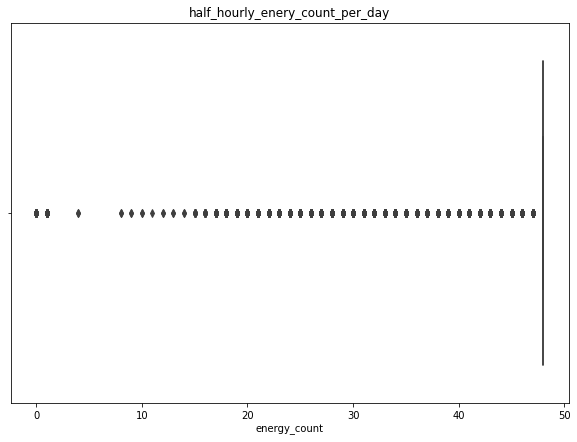

In [5]:
fig, ax = plt.subplots(figsize=(10,7))
sns.boxplot(daily['energy_count'])
plt.title("half_hourly_enery_count_per_day")
plt.savefig("half_hourly_count")

In [6]:
cum_freq = []
for i in range(1,49):
    cum_freq.append(np.sum(daily['energy_count']<=i)/len(daily))
    print("no. of imstances having daily count less than {} is {}".format(i, np.sum(daily['energy_count']<=i)/len(daily)))

no. of imstances having daily count less than 1 is 0.003227806940055543
no. of imstances having daily count less than 2 is 0.003227806940055543
no. of imstances having daily count less than 3 is 0.003227806940055543
no. of imstances having daily count less than 4 is 0.0032283766703423765
no. of imstances having daily count less than 5 is 0.0032283766703423765
no. of imstances having daily count less than 6 is 0.0032283766703423765
no. of imstances having daily count less than 7 is 0.0032283766703423765
no. of imstances having daily count less than 8 is 0.0032289464006292103
no. of imstances having daily count less than 9 is 0.0032295161309160436
no. of imstances having daily count less than 10 is 0.0032300858612028774
no. of imstances having daily count less than 11 is 0.003230370726346294
no. of imstances having daily count less than 12 is 0.0032309404566331274
no. of imstances having daily count less than 13 is 0.0032315101869199612
no. of imstances having daily count less than 14 is

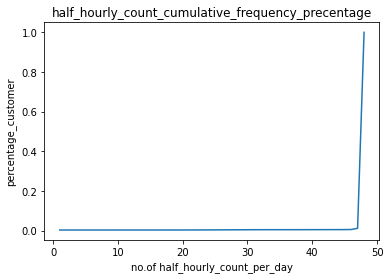

In [7]:
plt.plot(range(1,49), cum_freq)
plt.title("half_hourly_count_cumulative_frequency_precentage")
plt.xlabel("no.of half_hourly_count_per_day")
plt.ylabel("percentage_customer")
plt.savefig("cum_percentage_customer")

From the above plots and percentages we found that almost 99.99 precent people have all 48 half hourly counts per day **so we can drop those 0.01 percentage rows** as it is a nominal count.

This dropping will result in the removal of 6 IDS, which is nominal while analysing all remaining 5660 IDs

In [8]:
# dropping those rows which not have 48 hal_hourly count
daily = daily.drop(daily[(daily["energy_count"]<=47)].index.values, axis = 0)

### ID analysis on basis of data of total days count

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


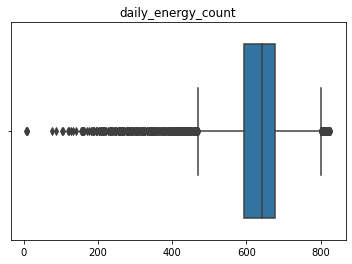

In [9]:
# plotting and finding outliers in daily_counts
sns.boxplot(daily.groupby("LCLid").size())
plt.title("daily_energy_count")
plt.savefig("daily_energy_count_boxplot")

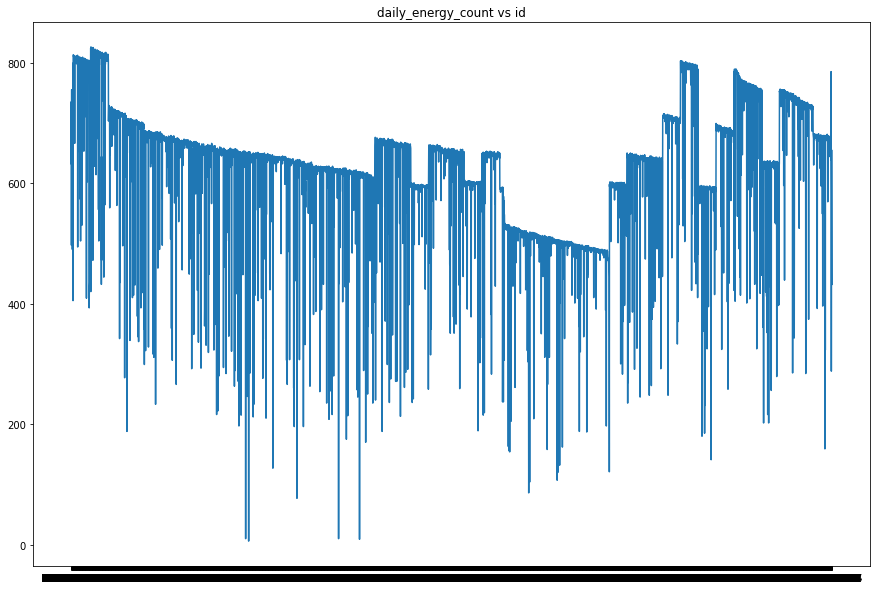

In [10]:
#particular ids count
plt.figure(figsize = (15,10))
daily_count = daily.groupby("LCLid").size()
plt.plot(daily_count.index, daily_count.values)
plt.title("daily_energy_count vs id")
plt.savefig("daily_energy_count vs id")

**Now we found that some of the ids have large duration which represents more instances, so we need to decide one period(Generally one year) where maximum number of ids will have enteries, so that the analysis can be fruitful**

### Evaluation of the range of useful days in the dataset¶


In [11]:
daily['day'] = pd.to_datetime(daily['day'])

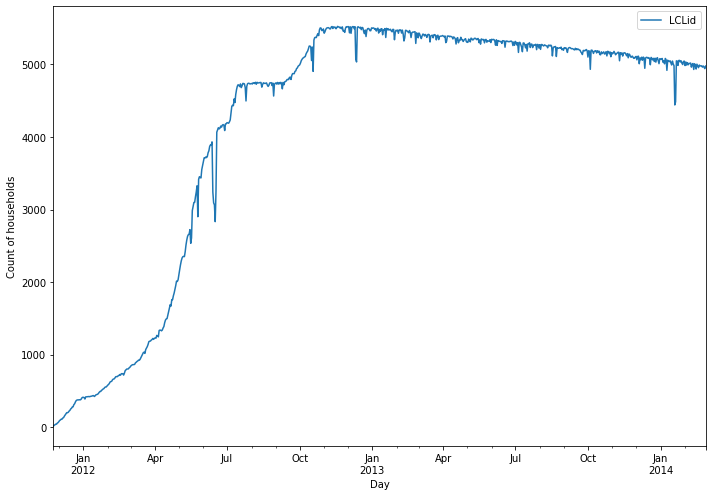

In [12]:
fig, ax = plt.subplots(figsize=(10,7))
daily.groupby("day").count()[["LCLid"]].plot(ax = ax)
plt.xlabel("Day")
plt.ylabel("Count of households")
fig.tight_layout()
plt.savefig("evaluation_of_days.png")

Now on the basis of above plot we will found that the maximum number of customers is at the time period of around 2013 so we will focus all our entire analysis on this period.

In [42]:
## Now filtering data for year 2013
final = daily[daily['day'].dt.year==2013]

**Now we will find the daily_counts for this particular year**

Max count can be 365(total days in this year)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'daily_energy_count_for_year_2013')

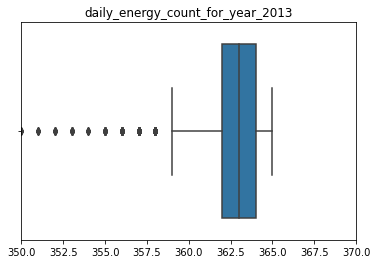

In [34]:
# plotting and finding outliers in daily_counts
sns.boxplot(final.groupby("LCLid").size())
plt.xlim(350,370)
plt.title("daily_energy_count_for_year_2013")

From the plot we will assume that 250 will be a good estimate above which the count need to be there for a customer, let's see how many are below this

In [35]:
# focus on selection criterai of 300 days at least
grpby = final.groupby("LCLid").size()
list_devices = list(grpby[grpby<=250].index)
print("Households below this threshold: {} households".format(len(list_devices)))

Households below this threshold: 295 households


so we will get around **5 percent ids** so we can ignore these ids and drop it to maintain regulaity

In [45]:
# removing those S percent ids
final = final[~final['LCLid'].isin(list_devices)]

In [46]:
# Now printing final unique_values
final.nunique()

LCLid               5233
day                  365
energy_median       8198
energy_mean       235695
energy_max          5869
energy_count           1
energy_std       1761717
energy_sum        281160
energy_min          1877
dtype: int64

### Temperature Data Analysis

In [47]:
weather

,temperatureMax,temperatureMaxTime,windBearing,icon,dewPoint,temperatureMinTime,cloudCover,windSpeed,pressure,apparentTemperatureMinTime,...,temperatureHigh,sunriseTime,temperatureHighTime,uvIndexTime,summary,temperatureLowTime,apparentTemperatureMin,apparentTemperatureMaxTime,apparentTemperatureLowTime,moonPhase
0,11.96,2011-11-11 23:00:00,123,fog,9.40,2011-11-11 07:00:00,0.79,3.88,1016.08,2011-11-11 07:00:00,...,10.87,2011-11-11 07:12:14,2011-11-11 19:00:00,2011-11-11 11:00:00,Foggy until afternoon.,2011-11-11 19:00:00,6.48,2011-11-11 23:00:00,2011-11-11 19:00:00,0.52
1,8.59,2011-12-11 14:00:00,198,partly-cloudy-day,4.49,2011-12-11 01:00:00,0.56,3.94,1007.71,2011-12-11 02:00:00,...,8.59,2011-12-11 07:57:02,2011-12-11 14:00:00,2011-12-11 12:00:00,Partly cloudy throughout the day.,2011-12-12 07:00:00,0.11,2011-12-11 20:00:00,2011-12-12 08:00:00,0.53
2,10.33,2011-12-27 02:00:00,225,partly-cloudy-day,5.47,2011-12-27 23:00:00,0.85,3.54,1032.76,2011-12-27 22:00:00,...,10.33,2011-12-27 08:07:06,2011-12-27 14:00:00,2011-12-27 00:00:00,Mostly cloudy throughout the day.,2011-12-27 23:00:00,5.59,2011-12-27 02:00:00,2011-12-28 00:00:00,0.10
3,8.07,2011-12-02 23:00:00,232,wind,3.69,2011-12-02 07:00:00,0.32,3.00,1012.12,2011-12-02 07:00:00,...,7.36,2011-12-02 07:46:09,2011-12-02 12:00:00,2011-12-02 10:00:00,Partly cloudy throughout the day and breezy ov...,2011-12-02 19:00:00,0.46,2011-12-02 12:00:00,2011-12-02 19:00:00,0.25
4,8.22,2011-12-24 23:00:00,252,partly-cloudy-night,2.79,2011-12-24 07:00:00,0.37,4.46,1028.17,2011-12-24 07:00:00,...,7.93,2011-12-24 08:06:15,2011-12-24 15:00:00,2011-12-24 13:00:00,Mostly cloudy throughout the day.,2011-12-24 19:00:00,-0.51,2011-12-24 23:00:00,2011-12-24 20:00:00,0.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
877,9.03,2014-01-26 16:00:00,233,partly-cloudy-day,2.39,2014-01-26 21:00:00,0.40,4.55,1002.10,2014-01-26 22:00:00,...,9.03,2014-01-26 07:48:49,2014-01-26 16:00:00,2014-01-26 11:00:00,Mostly cloudy until evening.,2014-01-27 05:00:00,-1.30,2014-01-26 15:00:00,2014-01-27 04:00:00,0.84
878,10.31,2014-02-27 14:00:00,224,partly-cloudy-day,3.08,2014-02-27 23:00:00,0.32,4.14,1007.02,2014-02-27 22:00:00,...,10.31,2014-02-27 06:51:45,2014-02-27 14:00:00,2014-02-27 12:00:00,Partly cloudy until evening.,2014-02-28 02:00:00,1.41,2014-02-27 14:00:00,2014-02-28 02:00:00,0.93
879,18.97,2014-03-09 14:00:00,172,partly-cloudy-night,4.30,2014-03-09 07:00:00,0.04,2.78,1022.44,2014-03-09 07:00:00,...,18.97,2014-03-09 06:29:49,2014-03-09 14:00:00,2014-03-09 12:00:00,Partly cloudy in the evening.,2014-03-10 05:00:00,7.08,2014-03-09 14:00:00,2014-03-10 06:00:00,0.28
880,8.83,2014-02-12 16:00:00,210,wind,1.94,2014-02-12 01:00:00,0.59,7.24,994.27,2014-02-12 01:00:00,...,8.83,2014-02-12 07:21:44,2014-02-12 16:00:00,2014-02-12 10:00:00,Mostly cloudy until evening and breezy through...,2014-02-13 05:00:00,-1.20,2014-02-12 16:00:00,2014-02-13 02:00:00,0.42


**For Temperature data**

We saw that it is not consistent with date hence it is better as of now to just using energy data irrespective of temperature for this particular data

### Aggregation over no. of days to form final features

In [57]:
aggregated1 = final.groupby("LCLid").mean().reset_index()
aggregated2 = final.groupby("LCLid").std().reset_index()
# Now we will use this aggregated overall mean and standard deviation data for our final smart meter analysis
final = pd.merge(aggregated1, aggregated2, on = "LCLid")

## 3. Clustering

Now we will perform Agglomerative clustering with cluster value = 3 as from our other analysis

In [66]:
from sklearn.cluster import AgglomerativeClustering as ac
cluster=ac(n_clusters=3, affinity='euclidean', linkage='ward')
arr = pd.DataFrame(cluster.fit_predict(final[final.columns[1:2]])) # base on mean energy
arr

,0
0,2
1,1
2,1
3,1
4,1
...,...
5228,1
5229,2
5230,1
5231,0


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


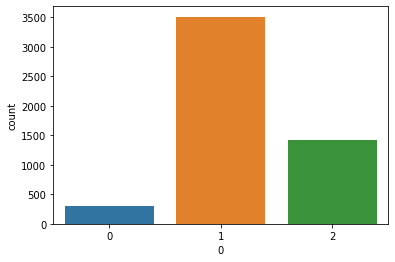

In [68]:
sns.countplot(arr[0])
plt.savefig("cluster_maps")

## 4. Data Manipulation

In [80]:
# based on this clustering we will choose the middle one for data manipulation

arr.value_counts()


1    3509
2    1416
0     308
dtype: int64

In [88]:
# Now we will randomly pick around 600 ids from cluster 1 for transformation
transform_indexes = list(arr[arr[0]==1].sample(600, random_state = 2).index)

# dividing these transformation into three types and appyling different transformations on it
in1 = transform_indexes[0:200]
in2 = transform_indexes[200:400]
in3 = transform_indexes[400:]



In [123]:
final_id = final["LCLid"]
final.drop("LCLid", axis = 1, inplace = True)

In [130]:
theft1 = final[final.index.isin(in1)].reset_index(drop = True)
theft2 = final[final.index.isin(in2)].reset_index(drop = True)
theft3 = final[final.index.isin(in3)].reset_index(drop = True)


In [137]:
theft1

,energy_median_x,energy_mean_x,energy_max_x,energy_count_x,energy_std_x,energy_sum_x,energy_min_x,energy_median_y,energy_mean_y,energy_max_y,energy_count_y,energy_std_y,energy_sum_y,energy_min_y
0,0.059711,0.254381,1.871767,45,0.429704,12.210265,0.002356,0.024966,0.169236,0.756800,0.0,0.241729,8.123327,0.004914
1,0.023562,0.031710,0.113294,9,0.024716,1.522084,0.011398,0.019200,0.018752,0.063797,0.0,0.019012,0.900106,0.001179
2,0.044355,0.059762,0.213266,37,0.044859,2.868563,0.016693,0.013648,0.010359,0.093606,0.0,0.016440,0.497248,0.003757
3,0.048925,0.074262,0.355967,27,0.079370,3.564552,0.003174,0.022060,0.028331,0.147953,0.0,0.027746,1.359876,0.008812
4,0.036829,0.073439,0.437179,47,0.096341,3.525051,0.009352,0.017886,0.053896,0.418790,0.0,0.098416,2.587010,0.004858
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.043817,0.060443,0.211648,13,0.048381,2.901284,0.012226,0.018943,0.018082,0.061595,0.0,0.014575,0.867920,0.003672
196,0.062347,0.086690,0.408646,22,0.085589,4.161120,0.010931,0.019128,0.024510,0.147728,0.0,0.032447,1.176483,0.007967
197,0.060816,0.075076,0.237483,36,0.047964,3.603638,0.018505,0.030668,0.029182,0.092491,0.0,0.011947,1.400758,0.026353
198,0.026165,0.035124,0.167769,9,0.030625,1.685952,0.013906,0.023632,0.025610,0.115778,0.0,0.018849,1.229268,0.018205


In [136]:
# Using standard normal distribution for transformation one number per row
for i in range(len(theft1)):
    val=np.random.rand()
    for k, va in theft1.iteritems():
        theft1[k][i]= theft1[k][i]*val

# Using beta distribution for transformation one number per row
for i in range(len(theft2)):
    val=np.random.beta(0.2, 0.5)
    for k, va in theft2.iteritems():
        theft2[k][i]= theft2[k][i]*val

# Using gamma distribution for transformation one number per row
for i in range(len(theft3)):
    val=np.random.gamma(2,3)
    for k, va in theft3.iteritems():
        theft3[k][i]= theft3[k][i]*val


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [140]:
theft1['label'] = 1
theft2['label'] = 1
theft3['label'] = 1

final['label'] = 0

data =pd.concat([final,theft1,theft2,theft3]).reset_index(drop=  True)

## 5. Model Building

In [146]:
from sklearn.model_selection import train_test_split
y = data["label"]
X = data[data.columns[:-1]]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify = y)

In [155]:
x_train.reset_index(drop = True, inplace = True)
x_test.reset_index(drop = True, inplace = True)
y_train.reset_index(drop = True, inplace = True)
y_test.reset_index(drop = True, inplace = True)

In [156]:
from optuna import Trial
import gc
import optuna
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier

def objective(trial:Trial):
    
    gc.collect()
    models=[]
    validScore=0
   
    model,log = fitLGBM(trial,x_train,y_train)
    
    models.append(model)
    gc.collect()
    validScore+=log
    validScore/=len(models)
    
    return validScore


420

In [188]:
def fitLGBM(trial,X, y):
    
    params={
      'n_estimators':trial.suggest_int('n_estimators', 0, 1000), 
      'num_leaves':trial.suggest_int('num_leaves', 2, 512),
      'max_depth':trial.suggest_int('max_depth', 2, 128),
      'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.15),
      'min_split_gain': trial.suggest_loguniform('min_split_gain', 0.001, 0.1),
      'feature_fraction':trial.suggest_uniform('feature_fraction',0.1, 1.0),
      'bagging_freq':trial.suggest_int('bagging_freq',0.1,10),
      'verbosity': -1,
      'random_state':44
            }
    stkfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=44)
    model = LGBMClassifier(**params, categorical_features = "auto")
    
    res=[]
    for i, (tdx, vdx) in enumerate(stkfold.split(X, y)):
        X_train, X_valid, y_train, y_valid = X.iloc[tdx], X.iloc[vdx], y[tdx], y[vdx]
        model.fit(X_train, y_train,
                 eval_set=[(X_train, y_train), (X_valid, y_valid)],
                 early_stopping_rounds=30, verbose=False)
        preds = model.predict_proba(X_valid)
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_valid, preds[:,1])
        # may differ
        print (auc(false_positive_rate, true_positive_rate))
        res.append(auc(false_positive_rate, true_positive_rate))
    err = np.mean(res)
    
    return model, err

In [189]:
study = optuna.create_study(direction='maximize', pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
study.optimize(objective,None , timeout=60*60*2)

[I 2021-04-28 19:27:40,977] A new study created in memory with name: no-name-f4da673d-1132-4080-b6c5-a4751fa14f1c
/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:565: UserWarning: The distribution is specified by [0.1, 10] and step=1, but the range is not divisible by `step`. It will be replaced by [0.1, 9.1].
  low=low, old_high=old_high, high=high, step=step


[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.606109761074764, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.606109761074764
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
1.0
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.606109761074764, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.606109761074764
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
1.0
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.606109761074764, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.606109761074764
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
1.0
[LightGBM] [Warning] Unkn

[I 2021-04-28 19:27:43,971] Trial 0 finished with value: 0.99888108248764 and parameters: {'n_estimators': 488, 'num_leaves': 397, 'max_depth': 61, 'learning_rate': 0.028140725025461166, 'min_split_gain': 0.0016468621934459184, 'feature_fraction': 0.606109761074764, 'bagging_freq': 8}. Best is trial 0 with value: 0.99888108248764.


1.0


/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:565: UserWarning: The distribution is specified by [0.1, 10] and step=1, but the range is not divisible by `step`. It will be replaced by [0.1, 9.1].
  low=low, old_high=old_high, high=high, step=step


[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.21829832251507167, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21829832251507167
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
1.0
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.21829832251507167, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21829832251507167
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
1.0
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.21829832251507167, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21829832251507167
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
1.0
[LightGBM] [W

[I 2021-04-28 19:27:47,419] Trial 1 finished with value: 0.9983021077283372 and parameters: {'n_estimators': 430, 'num_leaves': 194, 'max_depth': 121, 'learning_rate': 0.02560975446290483, 'min_split_gain': 0.07777884614835814, 'feature_fraction': 0.21829832251507167, 'bagging_freq': 0}. Best is trial 0 with value: 0.99888108248764.


1.0


/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:565: UserWarning: The distribution is specified by [0.1, 10] and step=1, but the range is not divisible by `step`. It will be replaced by [0.1, 9.1].
  low=low, old_high=old_high, high=high, step=step


[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.5149137171893795, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5149137171893795
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
1.0
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.5149137171893795, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5149137171893795
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
1.0
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.5149137171893795, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5149137171893795
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
1.0
[LightGBM] [Warning

[I 2021-04-28 19:27:49,154] Trial 2 finished with value: 0.9985981004423629 and parameters: {'n_estimators': 165, 'num_leaves': 56, 'max_depth': 91, 'learning_rate': 0.0011852963127421121, 'min_split_gain': 0.0018139136799910393, 'feature_fraction': 0.5149137171893795, 'bagging_freq': 2}. Best is trial 0 with value: 0.99888108248764.


1.0


/opt/conda/lib/python3.7/site-packages/optuna/distributions.py:565: UserWarning: The distribution is specified by [0.1, 10] and step=1, but the range is not divisible by `step`. It will be replaced by [0.1, 9.1].
  low=low, old_high=old_high, high=high, step=step


[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.7796344384585414, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7796344384585414
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
1.0
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.7796344384585414, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7796344384585414
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
1.0
[LightGBM] [Warning] Unknown parameter: categorical_features
[LightGBM] [Warning] feature_fraction is set=0.7796344384585414, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7796344384585414
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
1.0
[LightGBM] [Warning

KeyboardInterrupt: 

In [211]:
def lgb_f1_score(y_true, y_hat):

    y_hat= np.where(y_hat < 0.5, 0, 1)   # scikits f1 doesn't like probabilities
    return f1_score(y_true, y_hat, average = "micro")

opt_params = {'n_estimators': 10, 'num_leaves': 3, 'max_depth': 1, 'learning_rate': 0.0025520582238931075, 'min_split_gain': 0.016775737179389627, 'feature_fraction': 0.39391056554912707, 'bagging_freq': 7}
model = LGBMClassifier(**opt_params, random_state=44, metric = "auc")

stkfold = StratifiedKFold(n_splits=5, shuffle=True, random_state = 44)

def calc(X, y, model, cv):
    res=[]
    local_probs=pd.DataFrame()
    probs = pd.DataFrame()

    for i, (tdx, vdx) in tn(enumerate(cv.split(X, y))):
        X_train, X_valid, y_train, y_valid = X.iloc[tdx], X.iloc[vdx], y[tdx], y[vdx]
        #  X_train, y_train = smote.fit_resample(X_train, y_train)
        model.fit(X_train, y_train,
                 eval_set=[(X_train, y_train), (X_valid, y_valid)],
                 #eval_metric = evaluate_macroF1_lgb,
                 early_stopping_rounds=30, verbose=0)
        
        preds = model.predict_proba(X_valid)
       # preds1 = np.array(list(map(lambda x: 1 if x>0.5 else x, preds[:,1])))
       # print(preds1.shape)
        oof_predict = model.predict_proba(x_test)
        local_probs['fold_%i'%i] = oof_predict[:,1]
        # may differ
        false_positive_rate, true_positive_rate, thresholds = roc_curve(y_valid, preds[:,1])
        # may differ
        print (auc(false_positive_rate, true_positive_rate))
        res.append(auc(false_positive_rate, true_positive_rate))
        #print (lgb_f1_score(y_valid, preds[:,1]))
        #res.append(lgb_f1_score(y_valid, preds[:,1]))

    print('f1_Score:', round(np.mean(res), 6))    
    local_probs['res'] = local_probs.mean(axis=1)
    probs['target'] = local_probs['res']
    return probs

In [212]:
%%time
probs = calc(x_train, y_train, model, stkfold)

0it [00:00, ?it/s]

[LightGBM] [Warning] feature_fraction is set=0.39391056554912707, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.39391056554912707
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
0.8127070746443189
[LightGBM] [Warning] feature_fraction is set=0.39391056554912707, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.39391056554912707
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
0.8497693756902488
[LightGBM] [Warning] feature_fraction is set=0.39391056554912707, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.39391056554912707
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
0.8308321964529332
[LightGBM] [Warning] feature_fraction is set=0.39391056554912707, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3939105655491

In [210]:
y_pred = np.where(probs["target"]*5<0.506, 0, 1)
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[1314  256]
 [   0  180]]
              precision    recall  f1-score   support

           0       1.00      0.84      0.91      1570
           1       0.41      1.00      0.58       180

    accuracy                           0.85      1750
   macro avg       0.71      0.92      0.75      1750
weighted avg       0.94      0.85      0.88      1750

0.8537142857142858
